# Training Environment Sound Classification with Convolutional Neural Networks

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urbandata import k_fold_urban_sound, UrbanSoundDataSet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

device=device(type='cuda')


## Consts & Hyperparams

In [2]:
urban_root = Path('~/sound_datasets/urbansound8k').expanduser()
urban_metadata = urban_root / 'metadata/UrbanSound8K.csv'
urban_audio_path = urban_root / "audio/"

In [3]:
target_sample_rate = 22050
mel_kwargs = {
    'n_fft': 1024,
    'n_mels': 60
}

In [4]:
isShuffle = True
batch_size = 64
lr = 0.005
momentum = 0.9
EPOCHS=10

batch_print_threshold = 25

dry_run = False

## Network Setup

In [5]:
tmp_ds = UrbanSoundDataSet(urban_audio_path, ['fold5/100032-3-0-0.wav'], sample_rate=target_sample_rate, mel_kwargs=mel_kwargs)
X_shape = tmp_ds.getXShape()
print(f'Shape of model input, X: {X_shape}')

X_channels, X_rows, X_cols = X_shape

Shape of model input, X: torch.Size([2, 60, 173])


In [6]:
class SCCN(torch.nn.Module):
    '''The Simple CNN'''
    def __init__(self):
        super().__init__()
        
        # Recreating ESC paper, but with some modernization
        self.model = nn.Sequential(
            nn.Conv2d(X_channels, 30, 5),
            nn.BatchNorm2d(30),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(30, 60, kernel_size=5),
            nn.BatchNorm2d(60),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(60 * 12 * 40, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, X):
        return self.model(X)

## Training, with Cross Validation

In [7]:
folds = k_fold_urban_sound(urban_metadata, dry_run)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB

Summarizing folds:
-----------------------------------------------------------
Training set size for fold 1 : 7859
Training set info: 

Total samples: 7859
Class            | Frequency  | Percentage
----------------------------------------
engine_idling    | 904        | 11.50%
dog_bark         | 900        | 11.45%
children_playing | 900        | 11.45%
air_conditio

Training set size for fold 7 : 7894
Training set info: 

Total samples: 7894
Class            | Frequency  | Percentage
----------------------------------------
jackhammer       | 924        | 11.71%
dog_bark         | 900        | 11.40%
children_playing | 900        | 11.40%
air_conditioner  | 900        | 11.40%
drilling         | 900        | 11.40%
street_music     | 900        | 11.40%
engine_idling    | 894        | 11.33%
siren            | 852        | 10.79%
car_horn         | 401        | 5.08%
gun_shot         | 323        | 4.09%
----------------------------------------

Duration statistics: 
count    7894.000000
mean        3.602503
std         0.979639
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: duration, dtype: float64
Validation set size for fold 7 : 838
Validation set info: 

Total samples: 838
Class            | Frequency  | Percentage
----------------------------------------
engine_idling    | 106   

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
def train_one_epoch(epoch, dl, model, optimizer):
    model.train()
    
    running_loss = 0.
    running_batch_loss = 0.
    total = 0
    correct = 0
    avg_batch_loss = 0
    
    for batch_idx, batch in enumerate(dl):
        (Xs, ys) = batch['spectrogram'].to(device), batch['label'].to(device)
        
        optimizer.zero_grad()
        
        yhats = model(Xs)
        _, yhats_as_idx = torch.max(yhats, 1)
        
        loss = loss_fn(yhats, ys)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        running_batch_loss += loss.item()
        
        total += ys.size(0)
        correct += (ys == yhats_as_idx).sum().item()
        
#         print(f'Training ground truth {ys}')
#         print(f'Training predictions {yhats_as_idx}')
    
        if batch_idx % batch_print_threshold == batch_print_threshold-1:
            last_loss = running_loss / batch_print_threshold #batch loss
            avg_batch_loss = running_batch_loss / batch_print_threshold
            print(f'\tbatch {batch_idx+1} loss: {avg_batch_loss}')
            running_batch_loss = 0
            
    accuracy = correct / total 
    return running_loss / (batch_idx+1), accuracy

In [10]:
def validate(validation_dl, model, optimizer):
    model.eval()
    
    running_vloss = 0.
    total = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(validation_dl):
            (vXs, vys) = batch['spectrogram'].to(device), batch['label'].to(device)

            vyhats = model(vXs)
            _, vyhats_as_idx = torch.max(vyhats, 1)
            vloss = loss_fn(vyhats, vys)
            running_vloss += vloss
            
            total += vys.size(0)
            correct += (vys == vyhats_as_idx).sum().item()
#             print(f'Validation ground truth {vys}')
#             print(f'Validation redictions {vyhats_as_idx}')
    accuracy = correct/total
    return running_vloss.to('cpu') / (batch_idx+1), accuracy

In [11]:
def plot_fold_results(foldidx, losses_for_fold, acc_for_fold):
    plt.figure(figsize=(10, 6))
    train_losses, val_losses = zip(*losses_for_fold)
    train_acc, val_acc = zip(*acc_for_fold)
    print(train_acc)
    
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel(f'Losses for fold {foldidx}')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(train_acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel(f'Accuracy for fold {foldidx}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

-----10-Fold Cross Validation-----
Fold 0:
	Size of train, val datasets: (7859, 873)
Epoch 1
	batch 25 loss: 2.2754633808135987
	batch 50 loss: 2.239986944198608
	batch 75 loss: 2.2123952674865723
	batch 100 loss: 2.192725896835327
Epoch 2
	batch 25 loss: 2.1711747074127197
	batch 50 loss: 2.1577429008483886
	batch 75 loss: 2.150128345489502
	batch 100 loss: 2.1424314880371096
Epoch 3
	batch 25 loss: 2.106970815658569
	batch 50 loss: 2.092134141921997
	batch 75 loss: 2.0792311573028566
	batch 100 loss: 2.071829013824463
Epoch 4
	batch 25 loss: 2.054546051025391
	batch 50 loss: 2.02571813583374
	batch 75 loss: 2.047548756599426
	batch 100 loss: 2.020777530670166
Epoch 5
	batch 25 loss: 2.0084133434295652
	batch 50 loss: 1.9909218883514403
	batch 75 loss: 1.9970400619506836
	batch 100 loss: 2.0149879455566406
Epoch 6
	batch 25 loss: 1.9755606412887574
	batch 50 loss: 1.9768637084960938
	batch 75 loss: 1.9806889152526856
	batch 100 loss: 1.9913729572296142
Epoch 7
	batch 25 loss: 1.965963

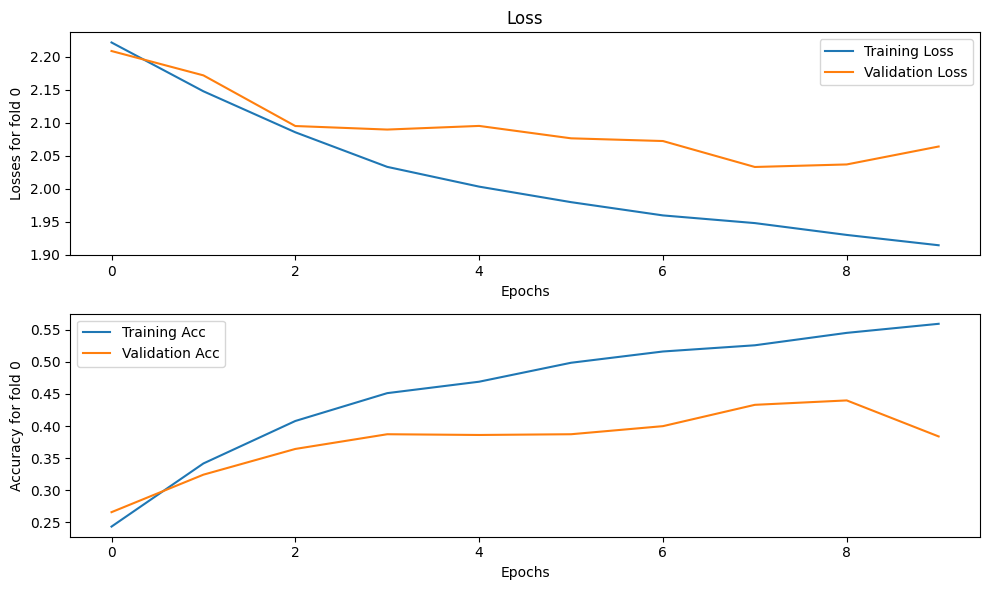

Fold 1:
	Size of train, val datasets: (7844, 888)
Epoch 1
	batch 25 loss: 2.275450658798218
	batch 50 loss: 2.252262554168701
	batch 75 loss: 2.2185085678100585
	batch 100 loss: 2.207966890335083
Epoch 2
	batch 25 loss: 2.1688484287261964
	batch 50 loss: 2.1531832027435303
	batch 75 loss: 2.153560075759888
	batch 100 loss: 2.12677321434021
Epoch 3
	batch 25 loss: 2.109718370437622
	batch 50 loss: 2.105934715270996
	batch 75 loss: 2.0441835927963257
	batch 100 loss: 2.0752755975723267
Epoch 4
	batch 25 loss: 2.0498074960708617
	batch 50 loss: 2.0362619161605835
	batch 75 loss: 2.0216272830963136
	batch 100 loss: 2.0282181882858277
Epoch 5
	batch 25 loss: 2.009405550956726
	batch 50 loss: 1.996028847694397
	batch 75 loss: 1.9989273262023926
	batch 100 loss: 1.99803635597229
Epoch 6
	batch 25 loss: 1.9771902894973754
	batch 50 loss: 1.9819081974029542
	batch 75 loss: 1.9757799196243286
	batch 100 loss: 1.9839721345901489
Epoch 7
	batch 25 loss: 1.9610857343673707
	batch 50 loss: 1.9708794

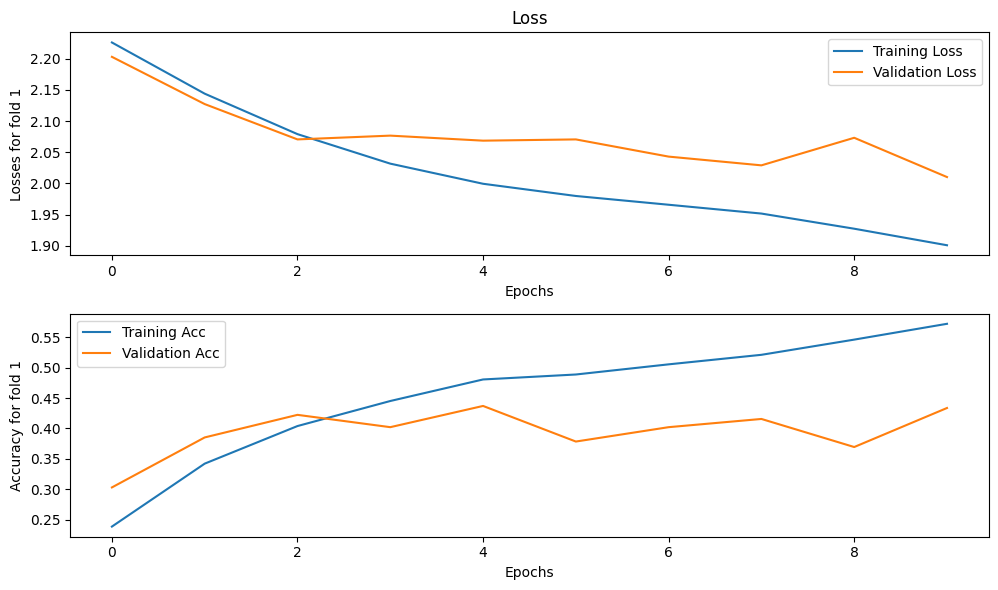

Fold 2:
	Size of train, val datasets: (7807, 925)
Epoch 1
	batch 25 loss: 2.2799241161346435
	batch 50 loss: 2.237464818954468
	batch 75 loss: 2.21878942489624
	batch 100 loss: 2.2088543510437013
Epoch 2
	batch 25 loss: 2.1890878009796144
	batch 50 loss: 2.1510533905029297
	batch 75 loss: 2.140723123550415
	batch 100 loss: 2.13480357170105
Epoch 3
	batch 25 loss: 2.0989499282836914
	batch 50 loss: 2.0878821563720704
	batch 75 loss: 2.071657180786133
	batch 100 loss: 2.0647212791442873
Epoch 4
	batch 25 loss: 2.022323570251465
	batch 50 loss: 2.0208824491500854
	batch 75 loss: 2.031496500968933
	batch 100 loss: 2.035434617996216
Epoch 5
	batch 25 loss: 1.9887499856948851
	batch 50 loss: 2.0071788454055786
	batch 75 loss: 1.9930174684524535
	batch 100 loss: 1.9766056632995606
Epoch 6
	batch 25 loss: 1.9583980226516724
	batch 50 loss: 1.9636002683639526
	batch 75 loss: 1.9694463443756103
	batch 100 loss: 1.9802233028411864
Epoch 7
	batch 25 loss: 1.9455477952957154
	batch 50 loss: 1.96758

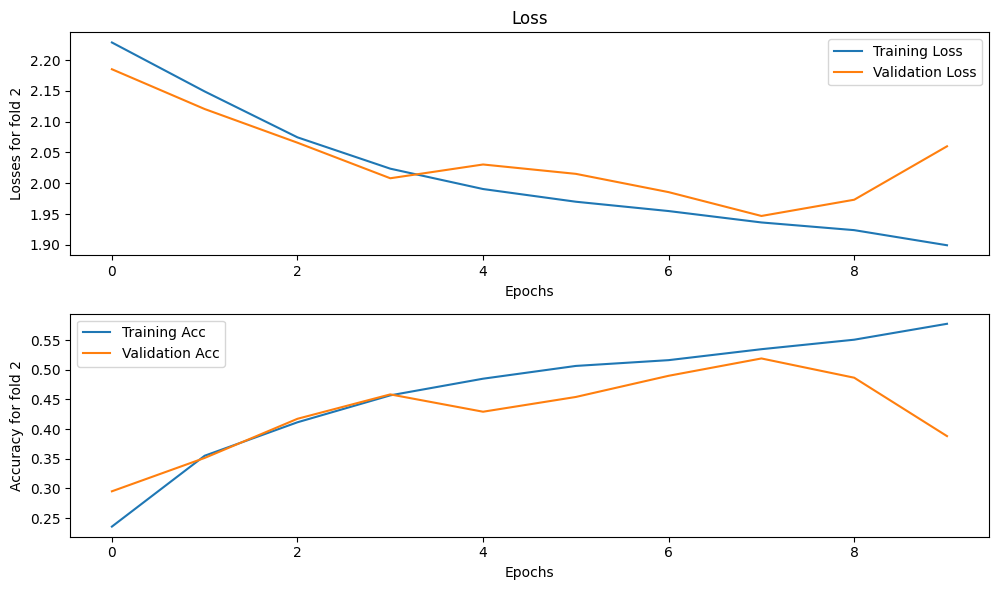

Fold 3:
	Size of train, val datasets: (7742, 990)
Epoch 1
	batch 25 loss: 2.2733320713043215
	batch 50 loss: 2.241459617614746
	batch 75 loss: 2.2279202938079834
	batch 100 loss: 2.2106534957885744
Epoch 2
	batch 25 loss: 2.1866362285614014
	batch 50 loss: 2.1716779708862304
	batch 75 loss: 2.1730498123168944
	batch 100 loss: 2.144244613647461
Epoch 3
	batch 25 loss: 2.1218201732635498
	batch 50 loss: 2.1031891250610353
	batch 75 loss: 2.1015139293670653
	batch 100 loss: 2.086917381286621
Epoch 4
	batch 25 loss: 2.050628547668457
	batch 50 loss: 2.048386173248291
	batch 75 loss: 2.037135624885559
	batch 100 loss: 2.042330780029297
Epoch 5
	batch 25 loss: 2.0350171899795533
	batch 50 loss: 2.0310244798660277
	batch 75 loss: 2.0125079584121703
	batch 100 loss: 2.024504041671753
Epoch 6
	batch 25 loss: 2.0087932252883913
	batch 50 loss: 1.9959910678863526
	batch 75 loss: 1.9874354696273804
	batch 100 loss: 2.002303304672241
Epoch 7
	batch 25 loss: 1.9653196716308594
	batch 50 loss: 1.9767

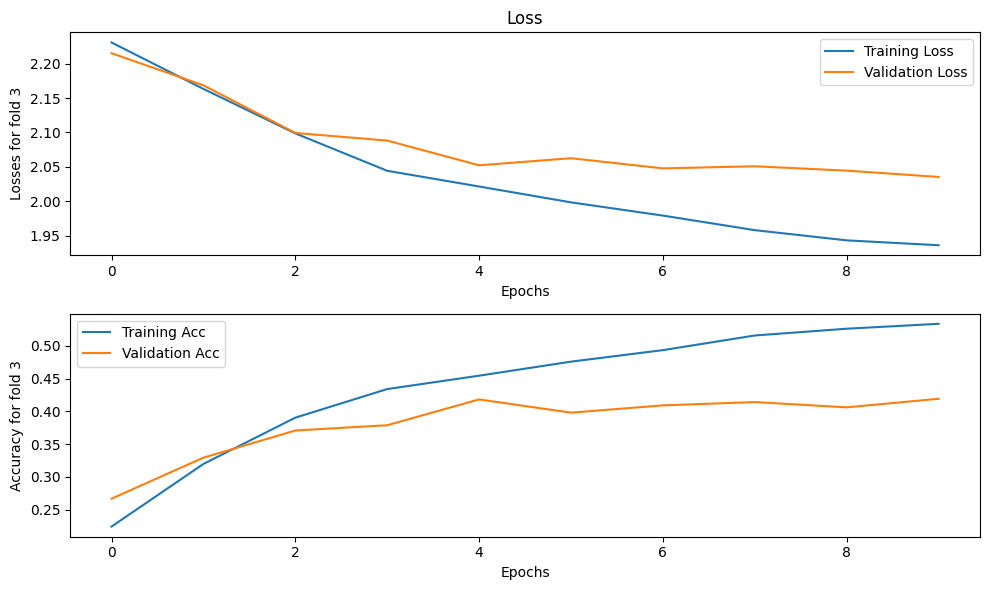

Fold 4:
	Size of train, val datasets: (7796, 936)
Epoch 1
	batch 25 loss: 2.282581958770752
	batch 50 loss: 2.2510748958587645
	batch 75 loss: 2.2281942653656004
	batch 100 loss: 2.2043466854095457
Epoch 2
	batch 25 loss: 2.1852480506896974
	batch 50 loss: 2.1798525142669676
	batch 75 loss: 2.165520257949829
	batch 100 loss: 2.1471585559844972
Epoch 3
	batch 25 loss: 2.1227237224578857
	batch 50 loss: 2.1033616924285887
	batch 75 loss: 2.1049199438095094
	batch 100 loss: 2.0709771013259886
Epoch 4
	batch 25 loss: 2.0431312084198
	batch 50 loss: 2.045161828994751
	batch 75 loss: 2.05040744304657
	batch 100 loss: 2.049124712944031
Epoch 5
	batch 25 loss: 2.0042679500579834
	batch 50 loss: 2.023564109802246
	batch 75 loss: 2.017064218521118
	batch 100 loss: 2.013761963844299
Epoch 6
	batch 25 loss: 2.006179442405701
	batch 50 loss: 1.9882329988479615
	batch 75 loss: 1.9978393173217774
	batch 100 loss: 1.9935378456115722
Epoch 7
	batch 25 loss: 1.982301197052002
	batch 50 loss: 1.972181754

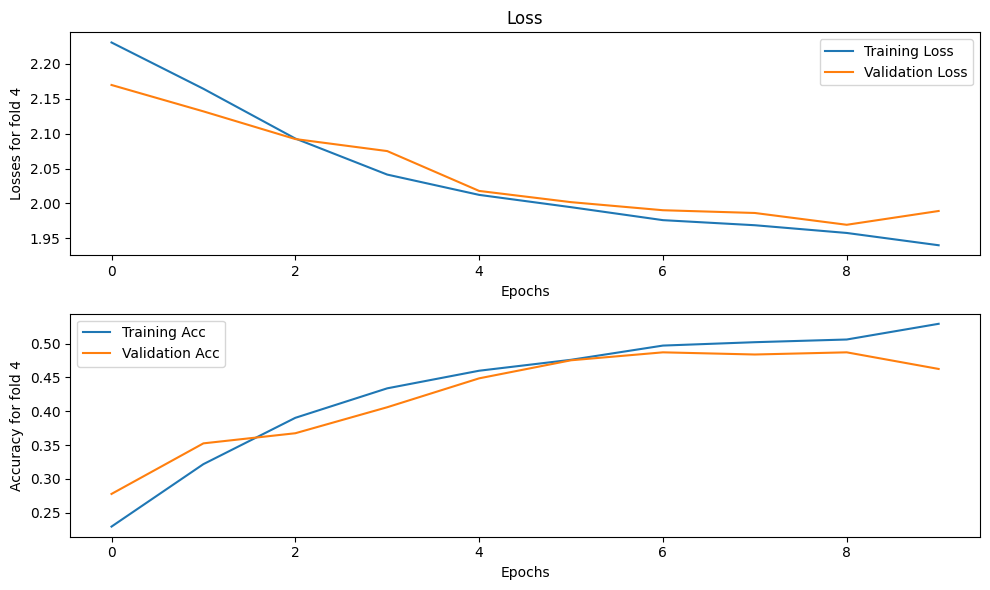

Fold 5:
	Size of train, val datasets: (7909, 823)
Epoch 1
	batch 25 loss: 2.278960771560669
	batch 50 loss: 2.243201913833618
	batch 75 loss: 2.220302381515503
	batch 100 loss: 2.2144800567626954
Epoch 2
	batch 25 loss: 2.1637812805175782
	batch 50 loss: 2.1624145317077637
	batch 75 loss: 2.1492743396759035
	batch 100 loss: 2.132152671813965
Epoch 3
	batch 25 loss: 2.1004795837402344
	batch 50 loss: 2.0939989948272704
	batch 75 loss: 2.079806408882141
	batch 100 loss: 2.0666739749908447
Epoch 4
	batch 25 loss: 2.0375763511657716
	batch 50 loss: 2.0409282350540163
	batch 75 loss: 2.0237031745910645
	batch 100 loss: 2.0303397798538207
Epoch 5
	batch 25 loss: 2.035385026931763
	batch 50 loss: 2.0126384496688843
	batch 75 loss: 1.9939037990570068
	batch 100 loss: 1.9854579210281371
Epoch 6
	batch 25 loss: 1.9977248907089233
	batch 50 loss: 1.9782888221740722
	batch 75 loss: 1.9859927415847778
	batch 100 loss: 2.00035653591156
Epoch 7
	batch 25 loss: 1.9700886249542235
	batch 50 loss: 1.978

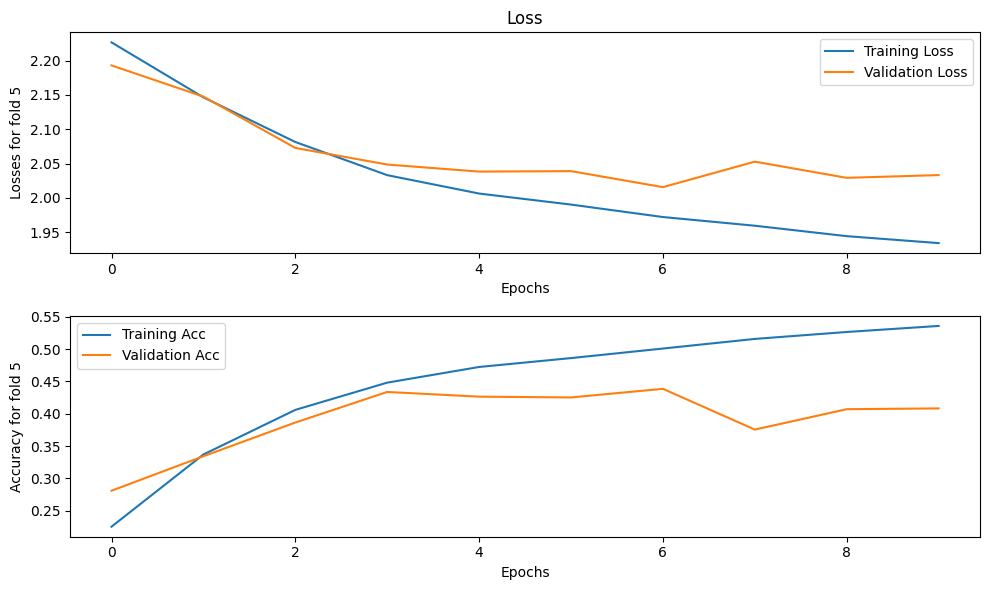

Fold 6:
	Size of train, val datasets: (7894, 838)
Epoch 1
	batch 25 loss: 2.2749188327789307
	batch 50 loss: 2.2342150020599365
	batch 75 loss: 2.2158336639404297
	batch 100 loss: 2.2056500339508056
Epoch 2
	batch 25 loss: 2.184657402038574
	batch 50 loss: 2.16369366645813
	batch 75 loss: 2.148610076904297
	batch 100 loss: 2.1392181873321534
Epoch 3
	batch 25 loss: 2.106514024734497
	batch 50 loss: 2.0912072467803955
	batch 75 loss: 2.0706346082687377
	batch 100 loss: 2.0625533390045168
Epoch 4
	batch 25 loss: 2.0385096406936647
	batch 50 loss: 2.0485390710830687
	batch 75 loss: 2.0455288743972777
	batch 100 loss: 2.03675341129303
Epoch 5
	batch 25 loss: 2.0170444107055663
	batch 50 loss: 2.0035978889465333
	batch 75 loss: 2.0100300216674807
	batch 100 loss: 2.021664743423462
Epoch 6
	batch 25 loss: 1.9950852823257446
	batch 50 loss: 2.0222818183898927
	batch 75 loss: 1.98332594871521
	batch 100 loss: 1.9945367622375487
Epoch 7
	batch 25 loss: 2.002251944541931
	batch 50 loss: 1.985424

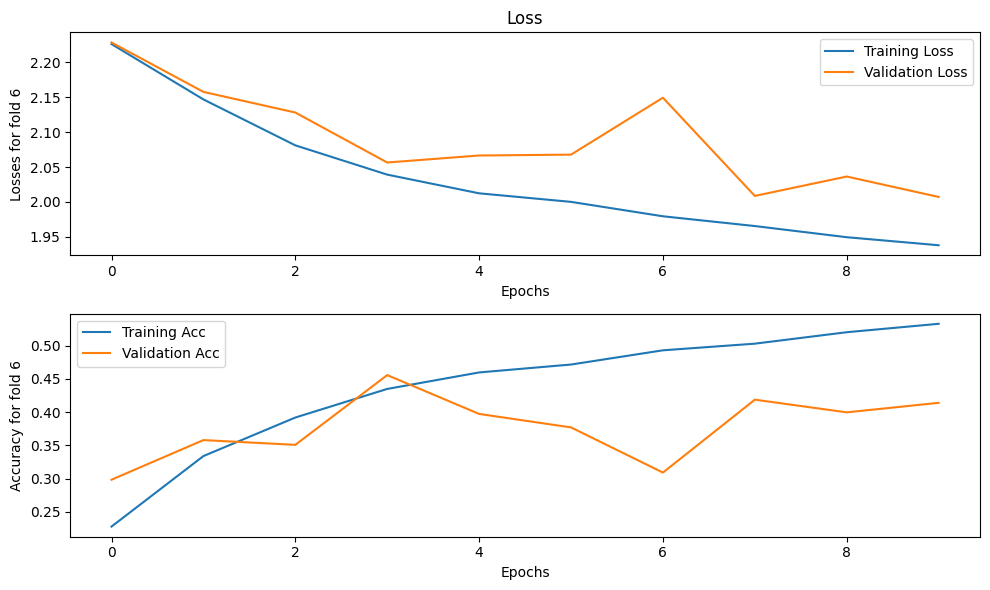

Fold 7:
	Size of train, val datasets: (7926, 806)
Epoch 1
	batch 25 loss: 2.2810265827178955
	batch 50 loss: 2.252713928222656
	batch 75 loss: 2.222029390335083
	batch 100 loss: 2.195115900039673
Epoch 2
	batch 25 loss: 2.172296199798584
	batch 50 loss: 2.142760200500488
	batch 75 loss: 2.1430816555023195
	batch 100 loss: 2.1073923301696778
Epoch 3
	batch 25 loss: 2.0803814792633055
	batch 50 loss: 2.0711963748931885
	batch 75 loss: 2.0618367910385134
	batch 100 loss: 2.0496124172210695
Epoch 4
	batch 25 loss: 2.0514810943603514
	batch 50 loss: 2.0338941526412966
	batch 75 loss: 2.0403730964660642
	batch 100 loss: 2.045847816467285
Epoch 5
	batch 25 loss: 2.0289598512649536
	batch 50 loss: 2.002291965484619
	batch 75 loss: 2.005743536949158
	batch 100 loss: 1.9993941068649292
Epoch 6
	batch 25 loss: 1.9885851097106935
	batch 50 loss: 1.978089723587036
	batch 75 loss: 2.0042448377609254
	batch 100 loss: 1.9834807062149047
Epoch 7
	batch 25 loss: 1.9727718448638916
	batch 50 loss: 1.9604

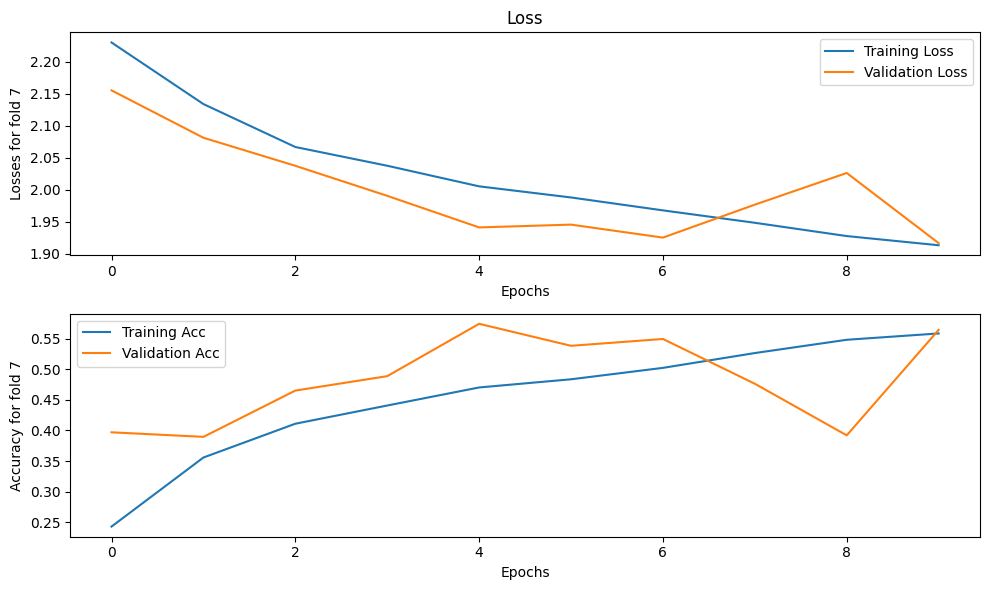

Fold 8:
	Size of train, val datasets: (7916, 816)
Epoch 1
	batch 25 loss: 2.2719686126708982
	batch 50 loss: 2.2374566078186033
	batch 75 loss: 2.2310222721099855
	batch 100 loss: 2.1854877567291258
Epoch 2
	batch 25 loss: 2.1652080821990967
	batch 50 loss: 2.1622909927368164
	batch 75 loss: 2.1343632888793946
	batch 100 loss: 2.1324535465240477
Epoch 3
	batch 25 loss: 2.082519588470459
	batch 50 loss: 2.0819246864318846
	batch 75 loss: 2.0726368713378904
	batch 100 loss: 2.0714972162246705
Epoch 4
	batch 25 loss: 2.0283630418777467
	batch 50 loss: 2.030494222640991
	batch 75 loss: 2.0630803728103637
	batch 100 loss: 2.0366910982131956
Epoch 5
	batch 25 loss: 2.0049818420410155
	batch 50 loss: 2.011495032310486
	batch 75 loss: 2.0208495903015136
	batch 100 loss: 2.0100911331176756
Epoch 6
	batch 25 loss: 1.989371852874756
	batch 50 loss: 2.0237720108032224
	batch 75 loss: 2.001248416900635
	batch 100 loss: 2.008078956604004
Epoch 7
	batch 25 loss: 1.9870801448822022
	batch 50 loss: 1.9

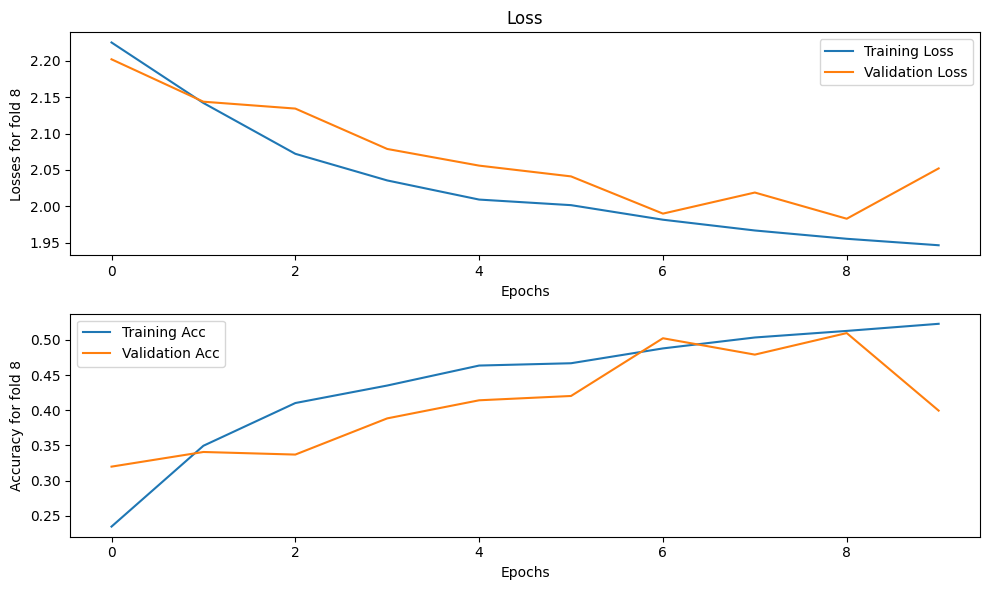

Fold 9:
	Size of train, val datasets: (7895, 837)
Epoch 1
	batch 25 loss: 2.2686338901519774
	batch 50 loss: 2.2302427005767824
	batch 75 loss: 2.2252374935150145
	batch 100 loss: 2.1988620567321777
Epoch 2
	batch 25 loss: 2.170175724029541
	batch 50 loss: 2.1540016555786132
	batch 75 loss: 2.1342232704162596
	batch 100 loss: 2.115302324295044
Epoch 3
	batch 25 loss: 2.08656476020813
	batch 50 loss: 2.0662134885787964
	batch 75 loss: 2.0610120487213135
	batch 100 loss: 2.057066445350647
Epoch 4
	batch 25 loss: 2.037008366584778
	batch 50 loss: 2.021302423477173
	batch 75 loss: 2.0313902950286864
	batch 100 loss: 2.045692663192749
Epoch 5
	batch 25 loss: 2.01334792137146
	batch 50 loss: 1.987953052520752
	batch 75 loss: 1.9922990322113037
	batch 100 loss: 2.0349376344680787
Epoch 6
	batch 25 loss: 2.026448955535889
	batch 50 loss: 1.9828458738327026
	batch 75 loss: 1.9539644384384156
	batch 100 loss: 1.9735987997055053
Epoch 7
	batch 25 loss: 1.9654017305374145
	batch 50 loss: 1.9894818

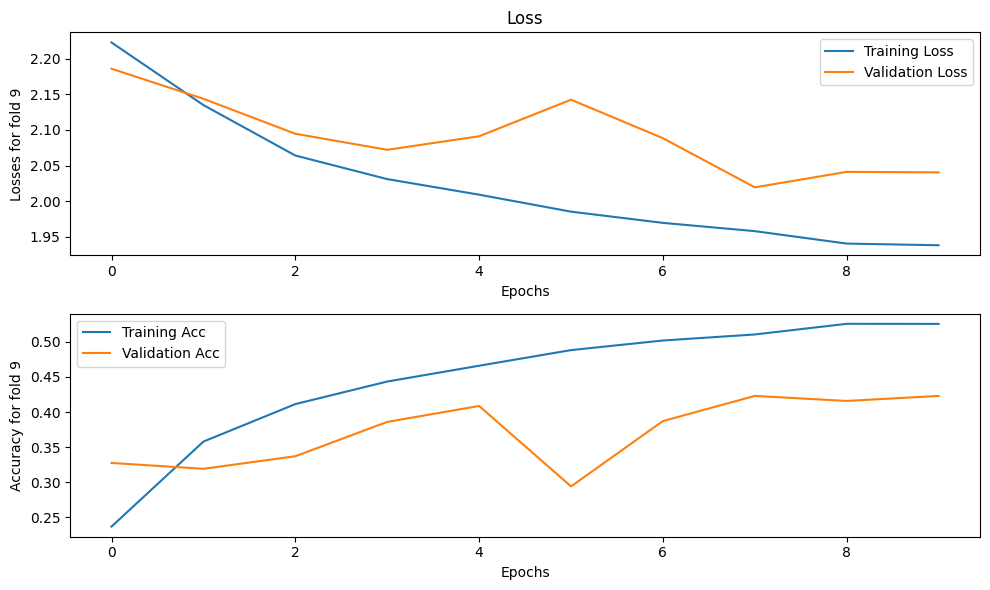

In [12]:
print(f'-----{len(folds)}-Fold Cross Validation-----')
for fold_idx, fold_bundle in enumerate(folds):
    print(f"Fold {fold_idx}:")
    
    model = SCCN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    train_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['train'], sample_rate=target_sample_rate, mel_kwargs=mel_kwargs)
    validation_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['validation'], sample_rate=target_sample_rate, mel_kwargs=mel_kwargs)
    print(f"\tSize of train, val datasets: {(len(train_ds), len(validation_ds))}")
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=isShuffle)
    validation_dl = DataLoader(validation_ds, batch_size=batch_size, shuffle=isShuffle)
    
    losses_for_fold, accs_for_fold = [], []
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}')
        
        avg_loss, acc = train_one_epoch(epoch, train_dl, model, optimizer)
        avg_vloss, vacc = validate(validation_dl, model, optimizer)
        
        losses_for_fold.append((avg_loss, avg_vloss))
        accs_for_fold.append((acc, vacc))
#         print(f'LOSS train {avg_loss} val {avg_vloss}')
        
    plot_fold_results(fold_idx, losses_for_fold, accs_for_fold)
